In [1]:
import jax
from jax import random, Array
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

from gp import PlotContext

key = random.PRNGKey(42)  # Create a random key                        

# Gaussian Processes (GP) and GP Regression

We will introduce **Gaussian Processes** (GPs) and **GP regression** in this notebook. We begin by reviewing **function approximation** which is a problem that can be solved with GP regression.

## Function Approximation

In **function approximation**, we attempt to learn an unknown function $f: \mathbb{R}^D \rightarrow \mathbb{R}$ from some hypothesis class $\mathcal{H}$ given a dataset $\mathcal{D} = \{(x_i, y_i) | x_i \in \mathbb{R}^D, y_i \in \mathbb{R} \}_{1 \leq i \leq N}$ of function input and output pairs $(x_i, y_i)$. We give an example of a dataset below.

In [2]:
def create_toy_dataset(f: Callable[[Array], Array]) -> tuple[Array, Array]:
    # Inputs
    xs = jnp.array([   # inputs
        [-2.],         # x_1
        [1],           # x_2
        [2.],          # x_3
    ])

    # Outputs
    ys = jax.vmap(f)(xs)

    return xs, ys

# Create dataset
f = lambda x: jnp.sin(x)
xs, ys = create_toy_dataset(f)
N = len(xs)
xs, ys

(Array([[-2.],
        [ 1.],
        [ 2.]], dtype=float32),
 Array([[-0.9092974],
        [ 0.841471 ],
        [ 0.9092974]], dtype=float32))

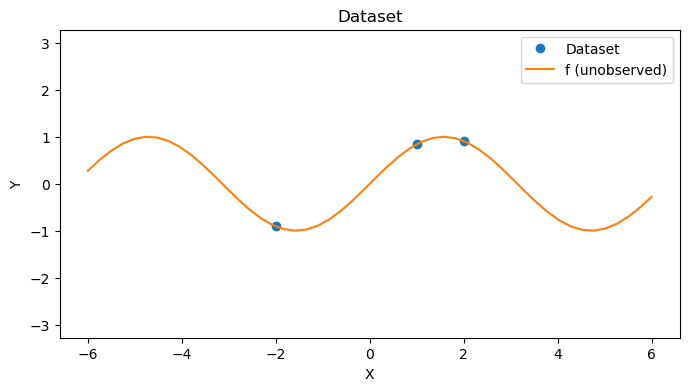

In [3]:
test_xs = jnp.linspace(-6, 6)

with PlotContext(title="Dataset", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    ax.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    ax.plot(test_xs, f(test_xs), label="f (unobserved)")

## Gaussian Processes (GPs)

A Gaussian Process (GP), written $GP(\mu, k)$, defines a distribution on continuous functions so that a draw $f \sim GP(\mu, k)$ from a GP is a function. It is parameterized by a **mean** fuction $\mu: \mathbb{R}^D \rightarrow \mathbb{R}$ and a positive semi-definite **kernel** function $k: \mathbb{R}^D \times \mathbb{R}^D \rightarrow \mathbb{R}$. Together, the mean and kernel functions control the shape of the functions sampled from a GP. Consequently, they enable the user to control the function hypothesis class used for function approximation.

### Mean

A **mean** function $\mu: \mathbb{R}^D \rightarrow \mathbb{R}$ is any real-valued function defined on the input space $\mathbb{R}^D$. A common choice is to use the constant $0$ function.

In [4]:
def mu(x: Array) -> float:
    """Constant mean function.
    """
    return 0

def mk_mean(mu: Callable, xs: Array) -> Array:
    return jax.vmap(mu)(xs)

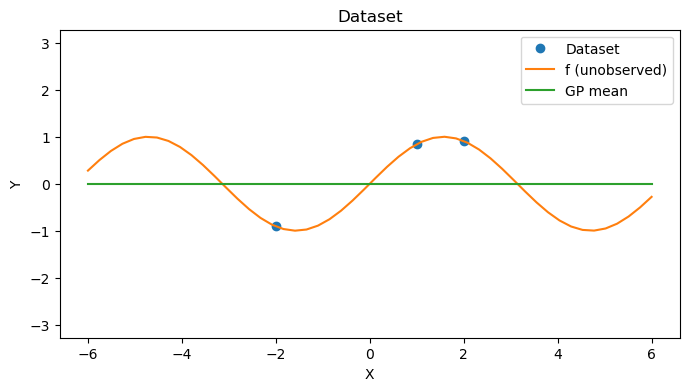

In [5]:
with PlotContext(title="Dataset", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(test_xs, f(test_xs), label="f (unobserved)")

    # Plot mean function
    plt.plot(test_xs, mk_mean(mu, test_xs), label="GP mean")

### Kernel

A **kernel** function $k: \mathbb{R}^D \times \mathbb{R}^D \rightarrow \mathbb{R}$ is any **positive semi-definite** function that compares two inputs from $\mathbb{R}^D$. It enables us to compare how similar or dissimilar its two inputs are.
- A kernel function controls the smoothness of the GP approximation.
- A popular kernel function is the **squared-exponential** kernel.

$$
k(x, x') = \exp \left(\frac{-\lVert x - x' \rVert^2}{2l^2} \right)
$$

In [6]:
def k(x: Array, y: Array, weight=1.0, length_scale=1.0) -> float:
    """The squared-exponential kernel function.
    """
    scaled_diff = (x - y) / length_scale
    radius2 = jnp.dot(scaled_diff, scaled_diff)
    c = (weight * weight)
    e = jnp.exp(-0.5 * radius2)
    return c * e

In [7]:
print("Disimilar", k(jnp.array([-1.]), jnp.array([1.])))
print("Similar", k(jnp.array([1.]), jnp.array([1.])))

Disimilar 0.13533528
Ssimilar 1.0


#### Covariance Matrix

Given a kernel function $k: \mathbb{R}^D \times \mathbb{R}^D \rightarrow \mathbb{R}$ and vectors of points $x = (x_1 \, \dots \, x_A)^T$ and $x' = (x_1' \, \dots \, x_B')^T$, we can construct a **covariance matrix**

$$
K_{xx'} = \begin{pmatrix}
k(x_1, x_1') & \dots & k(x_1, x_B') \\
\vdots & \ddots & \vdots \\
k(x_A, x_1') & \dots & k(x_A', x_B') \\
\end{pmatrix} \,.
$$

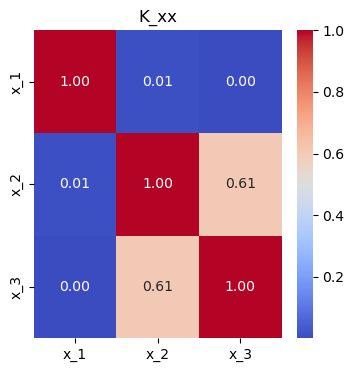

In [8]:
def mk_cov(k: Callable, xs1: Array, xs2: Array) -> Array:
    return jnp.stack([jnp.stack([k(x1, x2) for x2 in xs2]) for x1 in xs1])

K_xx = mk_cov(k, xs, xs)

# Plot
plt.figure(figsize=(4, 4))
sns.heatmap(
    K_xx, annot=True, cmap='coolwarm', fmt='.2f',
    xticklabels=["x_1", "x_2", "x_3"],
    yticklabels=["x_1", "x_2", "x_3"]
)
plt.title("K_xx");

### Gaussian Finite Dimensional Distributions

A GP has the property that if $f \sim GP(\mu, k)$, then

$$
\begin{pmatrix}
f(x_1) \\
\vdots \\
f(x_N)
\end{pmatrix} \sim \mathcal{N}(\mu_x, K_{xx})
$$

for any finite set of inputs $\{x_1, \dots, x_N \}$. This relates the functions that a GP is defining via $\mu$ and $k$ with the dataset.

1. The variable $\mu_x$ is the vector of mean values

$$
\mu_x = \begin{pmatrix}
\mu(x_1) \\
\vdots \\
\mu(x_N)
\end{pmatrix} \,.
$$

2. The variable $K_{xx}$ is the covariance matrix from before.
3. For simplicity of notation, we may drop the subscripts related to the datasets so we may simply write $\mu$ for the vector of means and $K$ for the covariance matrix.

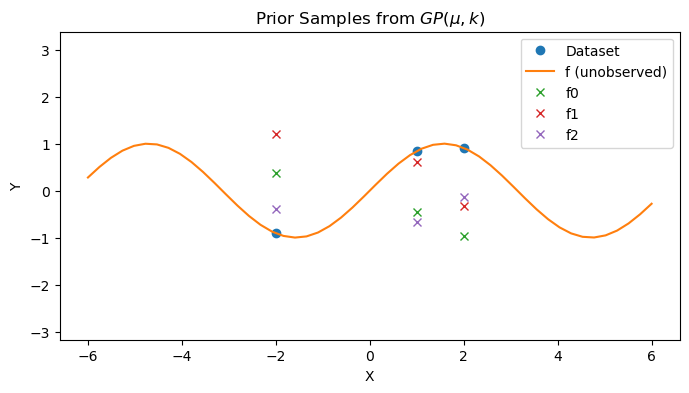

In [9]:
# Draw prior samples on the dataset of interest
m_x = mk_mean(mu, xs)
K_xx = mk_cov(k, xs, xs)
prior_ys = random.multivariate_normal(key, mean=m_x, cov=K_xx, shape=(3,))

with PlotContext(title=r"Prior Samples from $GP(\mu, k)$", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(test_xs, f(test_xs), label="f (unobserved)")

    # Plot prior samples
    for i, y in enumerate(prior_ys):
        plt.plot(xs, y, marker="x", linestyle="None", label=f"f{i}")

## Gaussian Process Regression

We now our attention to fitting a GP to a dataset $\mathcal{D} = \{(x_i, y_i) \}_{1 \leq i \leq N}$, i.e., performing GP regression. From the probabilistic perspective, this corresponds to computing a **posterior predictive distribution**.

### Generative Process

To perform GP regression, we assume the data is generated via the following **generative process**. Without loss of generality, we will assume that the mean $\mu$ is $0$ from now on since we can always center a Gaussian distribution (see Appendix: Centering).

\begin{align*}
f & \sim GP(\mu, k) \tag{random function from $GP(\mu, k)$}\\
e & \sim \mathcal{N}(0, \Sigma^{(N \times N)}) \tag{noise} \\
\begin{pmatrix}
y_1 \\
\vdots \\
y_N
\end{pmatrix} & = \begin{pmatrix}
f(x_1) + e_1 \\
\vdots \\
f(x_N) + e_N
\end{pmatrix} \tag{model}
\end{align*}

For simplicity of notation, we might simplify the above using vector notation as

$$
y = f(x) + e
$$

so that $y = (y_1 \, \dots \, y_N)^T$ and $f = (f(x_1) \, \dots \, f(x_N))^T$.

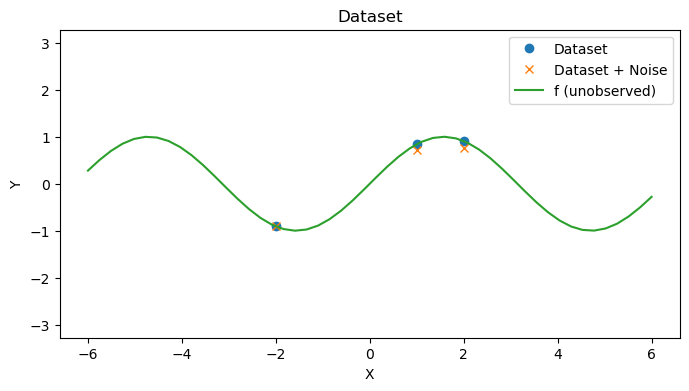

In [10]:
# 1. Sample noise
Sigma = jnp.diag(1e-2 * jnp.ones(N))
es = random.multivariate_normal(key, mean=jnp.zeros(N), cov=Sigma, shape=(1,)).transpose()

# 2. Produce observations
ys = jax.vmap(f)(xs) + es

with PlotContext(title="Dataset", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, jax.vmap(f)(xs), marker="o", linestyle="None", label="Dataset")
    plt.plot(xs, ys, marker="x", linestyle="None", label="Dataset + Noise")
    plt.plot(test_xs, f(test_xs), label="f (unobserved)")

### Posterior Predictive Distribution

1. Define a joint distribution on latent variables $f = (f(x_1) \, \dots \, f(x_N))^T$ (i.e., evaluated at $\{x_1, \dots, x_N\}$) and a test $f_* = f(x_*)$ (i.e., evaluated at $x_*$).

$$
p\begin{pmatrix}
f \\
f_*
\end{pmatrix} = \mathcal{N} \left( \begin{pmatrix}
0 \\
0
\end{pmatrix}, \begin{pmatrix}
K_{xx} & K_{x x_*} \\
K_{x_* x} & K_{x_* x_*}
\end{pmatrix} \right)
$$

    - We may use notation that conflates the dataset and the latent variables as $K_{ff} = K_{xx}$, $K_{*f} = K_{x_* x}$, $K_{f*} = K_{x x_*}$, and $K_{**} = K_{x_* x_*}$ to relate the covariance matrix to the function values as opposed to the function inputs.
    - Using this notation, we can rewrite the covariance matrix as 

$$
\begin{pmatrix}
K_{ff} & K_{f*} \\
K_{*f} & K_{**}
\end{pmatrix} = \begin{pmatrix}
K_{xx} & K_{x x_*} \\
K_{x_* x} & K_{x_* x_*}
\end{pmatrix} \,.
$$

2. Since we assume additive, independent, and Gaussian noise, we can write the conditional distribution $y = f(x) + e$ as

$$
p(y | f) = \mathcal{N}(f, \Sigma) \,.
$$

3. The **posterior predictive distribution** $p(f_* | y)$ of a GP's predictions on $f_*$ given the dataset is

$$
p(f_* | y) = \mathcal{N}(K_{*f}(K_{ff} + \Sigma)^{-1}y, K_{**} - K_{*f}(K_{ff} + \Sigma)^{-1}K_{f*}) \,.
$$

    - Note that $x$ is not random and so we do not condition on it.
    - The posterior predictive distribution indicates that GPs are closed under fitting so that a GP fit to data is again a GP.
    - See the Appendix for the explanation of the formula.
    - The time complexity of posterior mean inference is $O(N^3)$ which is the complexity of solving a system of linear equations.

In [11]:
def fit_gp(k: Callable, Sigma: Array, xs: Array, ys: Array) -> Array:
    K_xx = mk_cov(k, xs, xs)
    # Note: see Appendix for a better method than inverting a matrix
    alpha = jnp.linalg.inv(K_xx + Sigma) @ ys
    return K_xx, alpha

In [12]:
# Fit GP
_, alpha = fit_gp(k, Sigma, xs, ys)
alpha

Array([[-0.88656026],
       [ 0.4191331 ],
       [ 0.49450138]], dtype=float32)

In [13]:
def post_pred_mean(k: Callable, Sigma: Array, xs: Array, alpha, x_star: Array) -> Array:
    """Posterior predictive mean.
    """
    K_star_f = mk_cov(k, x_star, xs).reshape(-1)
    
    return (K_star_f @ jnp.linalg.inv(K_xx + Sigma) @ ys)

def post_pred_cov(k: Callable, Sigma: Array, xs: Array, K_xx: Array, x_star: Array) -> Array:
    """Posterior predictive covariance.
    """
    K_star_star = k(x_star, x_star)
    K_star_f = mk_cov(k, x_star, xs)
    return K_star_star - K_star_f @ jnp.linalg.inv(K_xx + Sigma) @ K_star_f.transpose()

#### Visualizing the posterior predictive

We can visualize the covariance of the posterior predictive by sampling a few times from the posterior predictive. Observe that the uncertainty away from from observed data points is higher than the uncertainty close to observed data points. Far away from the observed data points, the GP posterior predictive mean reverts to the prior.

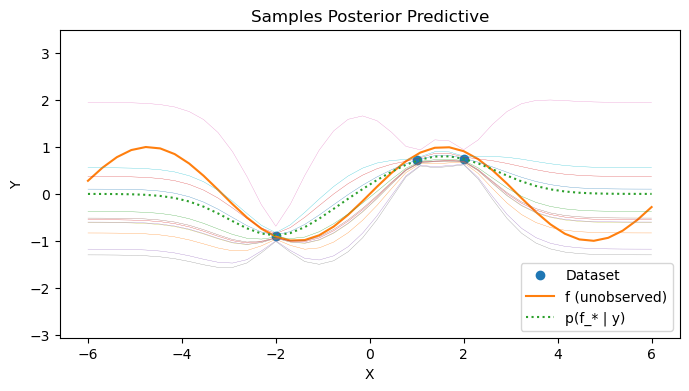

In [14]:
# Posterior Predictive
test_xs = jnp.linspace(-6, 6, 40).reshape(-1, 1)
post_mean = jax.vmap(lambda x_star: post_pred_mean(k, Sigma, xs, alpha, x_star))(test_xs)
post_cov = jax.vmap(lambda x_star: post_pred_cov(k, Sigma, xs, K_xx, x_star), out_axes=0)(test_xs)
post_ys = [random.normal(key, shape=(12,)) * jnp.sqrt(post_cov[i][0][0]) + post_mean[i] for i in range(len(test_xs))]

# Plot
with PlotContext(title="Samples Posterior Predictive", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(test_xs, f(test_xs), label="f (unobserved)")
    
    # Plot posterior samples
    plt.plot(test_xs, post_mean, linestyle="dotted", label="p(f_* | y)")
    plt.plot(test_xs, post_ys, linewidth=0.2)

## Summary

1. We introduced the GP model, a flexible function approximator based on Bayesian principles.
2. We also illustrated how to apply GPs to perform GP regression on a toy dataset.

## References

1. [Gaussian Processes for Machine Learning: Chapter 2](https://gaussianprocess.org/gpml/chapters/RW2.pdf)

## Appendix

### Appendix: GP Fitting Details

The mean of the posterior predictive distribution requires us to solve the following equation

$$
K_{xx}\alpha = y
$$

for $\alpha$. In our code above, we compute $K_{xx}^{-1}$. However, in practice, we try to avoid inverting a general matrix since it may be numerically less stable. There are at least two improvements we can make to the code.

1. Use **Gaussian elimination** to solve for $\alpha$ since we have $y$.
2. Use **Cholesky decomposition** to produce a lower (upper) triangular matrix since covariance matrices are positive semi-definite.
    - The Cholesky decomposition states that a positive semi-definite matrix $\Sigma$ can be decomposed as $\Sigma = LL^T$ where $L$ is lower triangular.
    
\begin{align*}
\Sigma \alpha = y \iff & LL^T \alpha = y \tag{$\Sigma = L^T L$} \\
\iff & L^T \alpha = \beta \text{   where $L \beta = y$} \tag{factor}
\end{align*}

In [15]:
def covariance_solve(K, b):
    L = jnp.linalg.cholesky(K)
    y = jax.scipy.linalg.solve_triangular(L, b, lower=True)
    return jax.scipy.linalg.solve_triangular(L.transpose(), y)

print("Inversion", jnp.linalg.inv(K_xx) @ ys)
print("Standard solve", jax.scipy.linalg.solve(K_xx, ys))
print("Cholesky solve", covariance_solve(K_xx, ys))

Inversion [[-0.8954498 ]
 [ 0.42117232]
 [ 0.49821255]]
Standard solve [[-0.89544976]
 [ 0.42117232]
 [ 0.49821255]]
Cholesky solve [[-0.89544976]
 [ 0.4211724 ]
 [ 0.49821252]]


### Appendix: Multivariate Normal

#### Mean centering

If $y_1 \sim \mathcal{N}(\mu_1, \Sigma)$ and $y_2 \sim \mathcal{N}(\mu_2, \Sigma)$, then

$$
y_1 + y_2 \sim \mathcal{N}(\mu_1 + \mu_2, \Sigma) \,.
$$

This means that the full posterior predictive $p(f_* | y)$ of a GP's predictions on $f_*$ given the dataset is

$$
p(f_* | y) = \mathcal{N}(K_{*f}(K_{ff} + \Sigma)^{-1}(y - \mu_x) + \mu_{x_*}, K_{**} - K_{*f}(K_{ff} + \Sigma)^{-1}K_{f*}) \,.
$$

#### Marginals and conditionals

Suppose

$$
\begin{pmatrix}
X \\
Y \\
\end{pmatrix} \sim \mathcal{N}\left( \begin{pmatrix}
\mu_X \\
\mu_Y 
\end{pmatrix}, \begin{pmatrix}
\Sigma_{XX} & \Sigma_{XY} \\
\Sigma_{YX} & \Sigma_{YY}
\end{pmatrix} \right) \,.
$$

Then
1. the marginal distribution is

$$
p(X) = \mathcal{N}(\mu_X, \Sigma_{XX}) \,,
$$

2. the conditional distribution is

$$
p(X | Y) = \mathcal{N}(\mu_X + \Sigma_{XY}\Sigma_{YY}^{-1}(Y - \mu_Y), \Sigma_{XX} - \Sigma_{XY}\Sigma_{YY}^{-1}\Sigma_{YX}) \,,
$$ 

3. and we replace $X$ with $Y$ to get $p(Y)$ and $p(Y | X)$.

Many properties of GPs are derived from using these formulas.